In [59]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
import geopandas as gpd
import numpy as np

# II

# Descargo tablas de referencia
lands = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/ldown_c.csv')
countries_ref = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/countries_ref.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [60]:
# III Merging the tables

# It's neccessary to merge the databases of lands(lands types) and world (geographic reference), 
# using countries_ref as a reference table, to obtain the main df with all the necessary data.

##########################################################
# The study is done just whith the data of the 2016 year #
##########################################################
lands = lands[lands.year==2016]

# Merge the three tables:
l_c = countries_ref.merge(lands,left_on='name_l', right_on='country')
w_l_c = world.merge(l_c,
                    left_on = world['name'].str.strip().str.lower(), 
                    right_on=l_c['name_w'].str.strip().str.lower()).drop(columns=['name', 'key_0'], axis=1)


# Replace the string of types in order of simplify their names
lrep = {'Land area (thousand hectares)':'LA',
        'Arable land (thousand hectares)': 'AL', 'Arable land (% of total land area)':'AL_%',
        'Forest cover (thousand hectares)':'FC', 'Forest cover (% of total land area)':'FC_%',
        'Permanent crops (thousand hectares)':'PC','Permanent crops (% of total land area)':'PC_%',
        'Important sites for terrestrial biodiversity protected (% of total sites protected)':'IB%'}

# Main df with al the data            
w_l_c['type'] = w_l_c['type'].map(lrep)

# IV
# Creating the dataframe to calcule the main indicators
AL = w_l_c[['name_l','name_w','pop_est','value', 'geometry', 'continent']][w_l_c['type']=='AL'].rename(columns={'value':'AL'}).reset_index(drop=True)
PC = w_l_c[['value']][w_l_c['type']=='PC'].rename(columns={'value':'PC'}).reset_index(drop=True)
LA = w_l_c[['value']][w_l_c['type']=='LA'].rename(columns={'value':'LA'}).reset_index(drop=True)

w_land = pd.concat([AL, PC, LA], axis=1, join='inner')

for name in ('name_w','name_l'):
    w_land[name] = w_land[name].str.strip()

def noNaN(df,values):
    for v in values:
        df[values] = df[values].replace(np.nan, 0)
        return df[values]

noNaN(w_land,['AL','PC','LA'])

# V
# Creating the indicators:
# CL, CL%(AL + PC), 'pop_est%', 'density' and 'density_CL', HpF, ref, ind
w_land['CL']= w_land['AL']+w_land['PC']
w_land['CL%']= 100*w_land['CL']/w_land['LA']
w_land['pop_est%'] = 100* w_land['pop_est']/w_land['pop_est'].sum()
w_land['density'] = (w_land['pop_est']/4)/(0.1 + w_land['LA']*1000)
w_land['density_CL'] = (w_land['pop_est']/4)/(0.1+w_land['CL']*1000)

ref_val = 1 #---->> Ha Reference Value!!!!

w_land['HpF'] = (4000) * w_land['CL']/w_land['pop_est']
w_land['ref'] = w_land['HpF'] - ref_val
w_land = w_land.sort_values(by=['continent', 'ref']).reset_index(drop=True)
w_land['name_l']= w_land['name_l'].str.capitalize()
w_land['ind'] = w_land['HpF'].apply(lambda x: 'over' if x >=ref_val else 'under')

## Exceptions:
w_land = w_land[~w_land['name_w'].str.contains('falkland is.|n. cyprus')] 


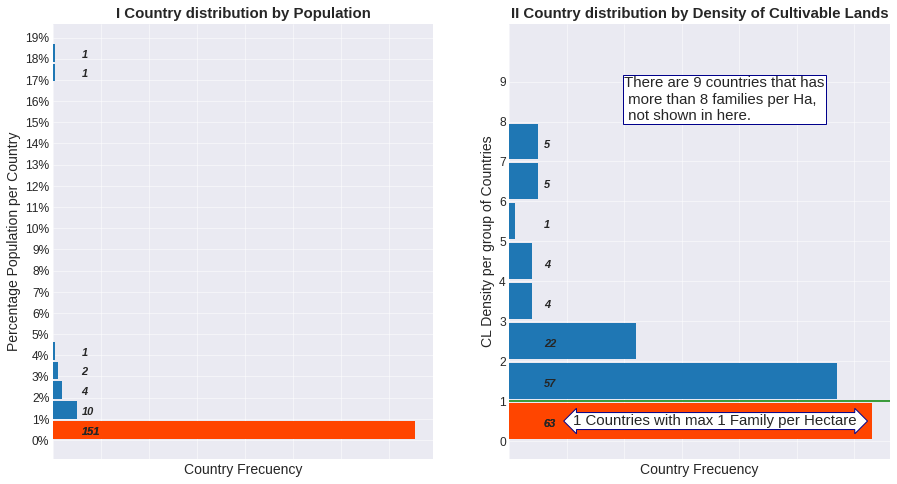

In [128]:
# VI Histogram division

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'xtick.labelsize':12,
                     'ytick.labelsize':12,
                     'ytick.labelleft':'on',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False, 
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     'xtick.top': False,
                     'axes.labelsize':14,
                     'axes.edgecolor':'slategrey',
                     'grid.linewidth':0.5
                    })


fig = plt.figure(figsize=(15,8))

#### GRAPH 1 ####
ax3 = fig.add_subplot(1,2,1)

ax3.set_ylabel('Percentage Population per Country')
ax3.set_xlabel('Country Frecuency')
ax3.set_title('I Country distribution by Population', weight='bold', size=15)

a_bins = 20
ax3, bins, patches3 = plt.hist(w_land['pop_est%'],
                               bins= a_bins, orientation='horizontal', rwidth=0.9)
patches3[0].set_fc('orangered')
plt.yticks(np.arange(0, 20, 1))

# Y axe in percentaje
fmt = '%.0f%%'
yticks = ticker.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

# # Adding the value of each bar (plot1)
high = 0.2
def texto(x):
    texto = lambda t: plt.text(x, high + t.xy[1], int(t.get_width()),size=11, 
                           fontweight='bold', fontstyle='oblique')
    return texto

vfunc1 = np.vectorize(texto(12))

## Filter the 0 width columns (plot1)
p1 = [patches3[i] for i in range(len(patches3)) if patches3[i].get_width() > 0]
vfunc1(p1)

#### GRAPH 2 ####
ax4 = fig.add_subplot(1,2,2)

ax4.set_ylabel('CL Density per group of Countries')
ax4.set_xlabel('Country Frecuency')
ax4.set_title('II Country distribution by Density of Cultivable Lands', weight='bold', size=15)

b_bins = 10
ax4, bins, patches4 = plt.hist(w_land['density_CL'],  orientation='horizontal', bins= b_bins,
                            range= [0,10], rwidth=0.9, bottom=0) 

# Text BBoxes with notes
plt.text(11, 0.35+patches4[0].xy[1], str(int(patches4[1].xy[1]))+' Countries with max 1 Family per Hectare', fontsize=15 ,
         bbox=dict(boxstyle='darrow,pad=0.1', fc='white', ec='darkblue'))
plt.text(20, 1+patches4[7].xy[1], 
         'There are 9 countries that has\n more than 8 families per Ha,\n not shown in here.', fontsize=15 ,
         bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='darkblue'))

# # Adding the value of each bar (plot2)
high = 0.3
p2 = [patches4[i] for i in range(len(patches4)) if patches4[i].get_width() > 0]

vfunc2 = np.vectorize(texto(6))
vfunc2(p2)

# # Aditional styling
plt.axhline(y=1, color='green') # Adding the reference line
plt.yticks(np.arange(0, 10, 1)) # Changing the y steps
patches4[0].set_fc('orangered')

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/hist_dens.png')

plt.show()
